In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import entropy
import copy
import pandas as pd
import math


# Transformer

## getTrainingData

In [94]:
def getTrainingData(songStrings,nrOfSongs):
    notes=list("ABCDEFGH")
    chord=[[0],
           [1],
           [2],
           [3],
           [4],
           [5],
           [6],
           [7]]
    source=[]
    target=[]
    song=[]
    for s in range(nrOfSongs):
        for i in range(42):
            sentence=[]
            answer=[]
            song.append(s)
            for j in range(41):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return numpy.array(source),numpy.array(target),numpy.array(song)

songStrings = numpy.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

I,O,S=getTrainingData(songStrings,4)
print(I.shape,O.shape,S.shape)

(168, 41) (168, 41) (168,)


In [95]:
len(songStrings[0])

42

In [96]:
S

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [83]:
I.shape

(84, 41)

In [19]:
print(I[0].flatten(),O[0].flatten())
print(I[1].flatten(),O[1].flatten())
print(I[2].flatten(),O[2].flatten())

print(I[-2].flatten(),O[-2].flatten())
print(I[-1].flatten(),O[-1].flatten())

[2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3] [2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2]
[2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2] [6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2]
[6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2] [6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3
 3 2 2 2]
[3 2 2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6
 5 5 4 4] [2 2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5
 5 4 4 3]
[2 2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5
 5 4 4 3] [2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3]


In [20]:
import numpy as np

def getTrainingData(songStrings, nrOfSongs):
    notes = list("ABCDEFGH")
    nrOfNotes = len(songStrings[0])  # Assuming all songs are the same length
    source = []
    target = []
    song = []
    
    for s in range(nrOfSongs):
        indices = [notes.index(note) for note in songStrings[s]]
        for i in range(nrOfNotes):
            # Create sequences by shifting manually
            sentence = indices[i:] + indices[:i]  # Wrap around to create circular shift
            source.append(sentence[:-1])  # Exclude the last to form the source sequence
            target.append(sentence[1:])   # Start from the second element to form the target sequence
            song.append(s)
    
    return np.array(source), np.array(target), np.array(song)

# Convert songStrings to a NumPy array for efficient indexing
songStrings = np.array([
    #"CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

I, O, S = getTrainingData(songStrings, 1)
print(I.shape, O.shape, S.shape)


(42, 41) (42, 41) (42,)


In [21]:
print(I[0].flatten(),O[0].flatten())
print(I[1].flatten(),O[1].flatten())
print(I[2].flatten(),O[2].flatten())
print(I[3].flatten(),O[3].flatten())
print(I[4].flatten(),O[4].flatten())

print(I[-4].flatten(),O[-4].flatten())
print(I[-3].flatten(),O[-3].flatten())
print(I[-2].flatten(),O[-2].flatten())
print(I[-1].flatten(),O[-1].flatten())

[0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 3 4] [1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5]
[1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5] [2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0]
[2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0] [3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1]
[3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1] [4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4
 5 0 1 2]
[4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4
 5 0 1 2] [5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5
 0 1 2 3]
[2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0] [3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 

## Transformer Model

In [19]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, emsize, nhead, d_hid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emsize, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntokens, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, ntokens)
        self.ntokens=ntokens
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,verbose=False):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        self.store=output.detach().numpy().copy()
        if verbose:
            print(output.shape)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)


c:\Users\ahmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Test

In [20]:
def test(model, source, target):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        
        # The output is [sequence_length, batch_size, ntokens]. Get the most likely token predictions
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability
        #print(predictions)
        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions
        
    accuracy = correct / total  # Calculate the accuracy
    return accuracy

## Train

C:\Users\ahmad\AppData\Local\Temp\ipykernel_24832\4185048613.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
C:\Users\ahmad\AppData\Local\Temp\ipykernel_24832\4185048613.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)
C:\Users\ahmad\AppData\Local\Temp\ipykernel_24832\1989781991.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
C:\Users\ahmad\AppData\Local\Temp\ipykernel_24832\1989781991.

Epoch 1, Loss: 0.0124
acc: 0.13893728222996515
Epoch 101, Loss: 0.0085
acc: 0.4880952380952381
Epoch 201, Loss: 0.0051
acc: 0.6672473867595818
Epoch 301, Loss: 0.0026
acc: 0.8549651567944251
Epoch 401, Loss: 0.0014
acc: 0.9208768873403019
Epoch 501, Loss: 0.0009
acc: 0.9465737514518002
Epoch 601, Loss: 0.0007
acc: 0.9590592334494773
Epoch 701, Loss: 0.0006
acc: 0.962979094076655
Epoch 801, Loss: 0.0008
acc: 0.9532520325203252
Epoch 901, Loss: 0.0006
acc: 0.9658826945412311
Epoch 1001, Loss: 0.0005
acc: 0.9679152148664344
Epoch 1101, Loss: 0.0005
acc: 0.9693670150987224
Epoch 1201, Loss: 0.0005
acc: 0.9700929152148664


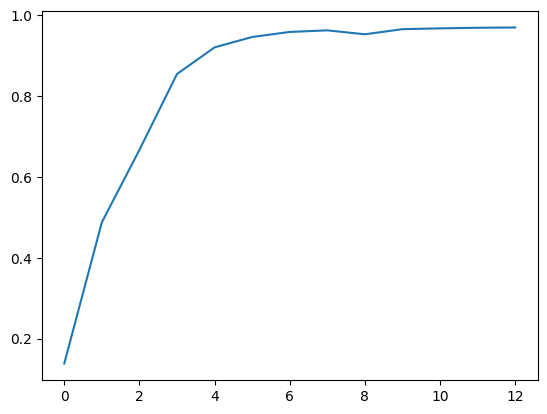

In [23]:
def train(model, source, target, num_epochs=1000, learning_rate=1e-3):
    W=[]
    model.train()  # Set the model to training mode
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Assuming source and target are numpy arrays of shape (sentences, 41) and need to be converted to tensors
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        # Here, we assume batching is handled externally, and source is directly fed into the model
        optimizer.zero_grad()  # Clear the gradients of all optimized tensors
        
        # Adjust for PyTorch expecting (sequence_length, batch_size), so we transpose source and target
        src = source.transpose(0, 1)  # Now shape [41, sentences]
        tgt = target.transpose(0, 1)  # Now shape [41, sentences]
        
        output = model(src)  # Forward pass: compute the output of the model
        
        # Output is [sequence_length, batch_size, ntokens], target is [sequence_length, batch_size]
        # Flatten output to [sequence_length*batch_size, ntokens] for compatibility with CrossEntropyLoss
        output_flat = output.view(-1, model.ntokens)
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(output_flat, tgt_flat)  # Compute the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        
        total_loss += loss.item()
        
        avg_loss = total_loss / src.size(1)  # average loss per sentence
        if epoch % 100 ==0:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            W.append(test(model,source,target))
            print("acc:",W[-1])
        if  W[-1]>0.97:
            break    
    return W
# Example usage
# Assuming `model` is your model instance, and `source`, `target` are your data tensors

ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.00  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

nrOfSongs=4
source,target,songs=getTrainingData(songStrings,nrOfSongs)

W=train(model, torch.tensor(source), torch.tensor(target),num_epochs=5000)
plot(W)

In [24]:
model.store[-1].shape

(168, 20)

In [37]:
source,target,songs=getTrainingData(songStrings,4)


In [38]:
source.shape

(168, 41)

In [39]:
target.shape

(168, 41)

In [40]:
songs.shape

(168,)

In [29]:
test(model,torch.tensor(source),torch.tensor(target))

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/1989781991.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/1989781991.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


0.9700929152148664

## predict_next_token

In [201]:
def predict_next_token(model, token_indices,verbose=False):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Convert the list of token indices to a PyTorch tensor and add a batch dimension
    src = torch.tensor(token_indices, dtype=torch.long).unsqueeze(1)  # Shape [sequence_length, 1] to match expected input

    with torch.no_grad():
        output = model(src,verbose)  # Get model output for the entire sequence

    # Assuming output is [sequence_length, 1, ntokens] and we're interested in the last token's prediction
    last_token_logits = output[-1, 0, :]  # Get logits for the last token
    predicted_token_index = last_token_logits.argmax().item()  # Find the index of the max log-probability
    
    return predicted_token_index

# Example usage:
# Assuming you have a `model` instance and a sentence represented as a list of token indices
# token_indices = [1, 2, 3, 2, 1, 2, 3, ...]
who=34
source[who]
predicted_token_index = predict_next_token(model, source[who],verbose=True)
print(f'Predicted next token index: {predicted_token_index}')
print(target[who][-1])

RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float

In [31]:
    for i in range(len(songs)):
        print(i,songs[i])
        print("source",source[i])


0 0
source [0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 3 4]
1 0
source [1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5]
2 0
source [2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0]
3 0
source [3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1]
4 0
source [4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4
 5 0 1 2]
5 0
source [5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5
 0 1 2 3]
6 0
source [0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 3 4]
7 0
source [1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5]
8 0
source [2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0]
9 0
source [3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1]
10 0
source [4 5 0 1 2 3 4 5 0 1 2 3 4 5

## Transformer  shrinkingDecompositionInformation

(20, 168)
(20, 168)


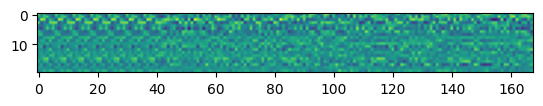

In [32]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def getAllIOH(model,source,target,songs,width=20):
    I=[]
    O=[]
    H=[]
    for i in range(len(songs)):
        I.append(songs[i])
        predicted_token_index = predict_next_token(model, source[i])
        if predicted_token_index==target[i][-1]:
            O.append(songs[i])
        else:
            O.append((songs[i]+1)%max(songs))
        H.append(list(model.store[-1].flatten()))
    H=numpy.array(H).transpose()
    print(H.shape)
    imshow(H)
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
    print(B.shape)
    H=numpy.zeros((H.shape[1]))
    for i in range(width):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return numpy.array(I),numpy.array(O),H

def shrinkingDecompositionInformation(model,source,target,songs,numbers=[0,1,2,3],width=20):
    allI,allO,H=getAllIOH(model,source,target,songs,width=width)
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=(1*(songs==number)).astype(int)
        O=(1*(allO==number)).astype(int)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

s,h=shrinkingDecompositionInformation(model,source,target,songs,numbers=list(range(5)),width=20)

In [33]:
M=removalIntoMatrix(s,20,h)

In [34]:
print(M.shape)

(5, 20)


0.7993386655816854 0.0


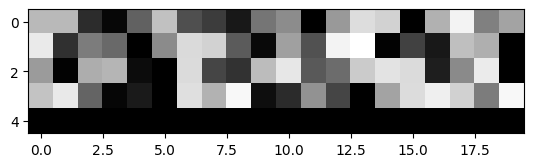

In [35]:
imshow(M,cmap="gray")
print(M.max(),M.min())

In [36]:
print(M.mean(),M.std())

0.3139788132777146 0.28518808249275135


In [37]:
print(songs)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


(20, 168)
(20, 168)


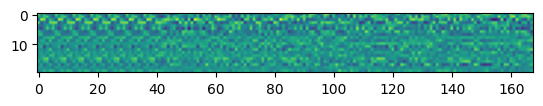

In [38]:
allI,allO,H=getAllIOH(model,source,target,songs,width=20)

In [39]:
number=5
I=(1*(songs==number)).astype(int)
O=(target.transpose()[-1]==allO)

In [40]:
allI

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [41]:
allO

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [42]:
allI

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
model.state_dict().keys()
#model.state_dict().values()

odict_keys(['pos_encoder.pe', 'transformer_encoder.layers.0.self_attn.in_proj_weight', 'transformer_encoder.layers.0.self_attn.in_proj_bias', 'transformer_encoder.layers.0.self_attn.out_proj.weight', 'transformer_encoder.layers.0.self_attn.out_proj.bias', 'transformer_encoder.layers.0.linear1.weight', 'transformer_encoder.layers.0.linear1.bias', 'transformer_encoder.layers.0.linear2.weight', 'transformer_encoder.layers.0.linear2.bias', 'transformer_encoder.layers.0.norm1.weight', 'transformer_encoder.layers.0.norm1.bias', 'transformer_encoder.layers.0.norm2.weight', 'transformer_encoder.layers.0.norm2.bias', 'transformer_encoder.layers.1.self_attn.in_proj_weight', 'transformer_encoder.layers.1.self_attn.in_proj_bias', 'transformer_encoder.layers.1.self_attn.out_proj.weight', 'transformer_encoder.layers.1.self_attn.out_proj.bias', 'transformer_encoder.layers.1.linear1.weight', 'transformer_encoder.layers.1.linear1.bias', 'transformer_encoder.layers.1.linear2.weight', 'transformer_encode

In [231]:
I.shape

(41, 8)

In [232]:
O.shape

(41, 8)

# RNN models

## RNN

In [3]:
class SimpleRNNModel(nn.Module):
    def __init__(self):
        super(SimpleRNNModel, self).__init__()
        self.expansion_layer = nn.Linear(in_features=8, out_features=20)
        self.rnn_layer = nn.RNN(input_size=20, hidden_size=20, batch_first=True)
        self.output_layer = nn.Linear(in_features=20, out_features=8)

    def forward(self, x):
        x = torch.relu(self.expansion_layer(x))
        x, _ = self.rnn_layer(x)
        x = self.output_layer(x)  # Removed softmax here
        return x


## generateIOData each song without combinations 

(41, 8) (41,)
[1. 0. 0. 0. 0. 0. 0. 0.] [1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 0]


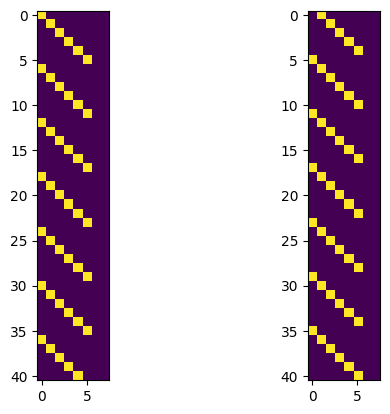

In [4]:
songStrings = numpy.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

notes=list("ABCDEFGH")

def generateIOData(songNr, songStrings=songStrings):
    notes=list("ABCDEFGH")
    I = np.zeros((41, 8))
    O = np.zeros(41, dtype=int)  # Now preparing O as indices directly
    raw =numpy.zeros((41,8)) # Now preparing O as indices directly
    for i in range(41):
        note_index = notes.index(songStrings[songNr][i])
        I[i][note_index] = 1.0
        raw[i][notes.index(songStrings[songNr][i+1])]=1.0
        if i < 40:  # Adjusting for O to capture the next note as index
            O[i] = notes.index(songStrings[songNr][i + 1])
    return I, O, raw

I,O, raw=generateIOData(1)
print(I.shape,O.shape)
print(I[0],O)
subplot(1,2,1)
imshow(I)
subplot(1,2,2)
imshow(raw)

In [17]:
model = SimpleRNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 2000
number_of_Songs = 4
songs = list(range(number_of_Songs))
L = []
A = []
for epoch in range(num_epochs):
    np.random.shuffle(songs)
    lo=numpy.zeros((number_of_Songs))
    acc=numpy.zeros((number_of_Songs))
    total_loss = 0
    total_accuracy = 0
    for song in songs:
        I, O, raw = generateIOData(song)
        inputs = torch.tensor(I, dtype=torch.float).unsqueeze(0)  # Add batch dimension
        targets = torch.tensor(O, dtype=torch.long)  # Targets are now indices

        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 8), targets)  # Reshape for CrossEntropyLoss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted_indices = torch.max(outputs, 2)
        accuracy = (predicted_indices.squeeze() == targets).float().mean().item()
        acc[song] = accuracy
        total_accuracy += accuracy
        lo[song]=loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss / number_of_Songs}, Accuracy: {total_accuracy / number_of_Songs}')
        print(f'Epoch {epoch+1}, Loss: {mean(lo)}, Losses: {numpy.round(lo,2)}')
        print(f'Epoch {epoch+1}, Accuracy: {mean(acc)}, Accuracies: {numpy.round(acc,2)}')
        
    L.append(total_loss / number_of_Songs)
    A.append(total_accuracy / number_of_Songs)
    
    if len(A)>= 2000 or total_accuracy / number_of_Songs >0.97:
      break
  
  
  


Epoch 1, Loss: 2.1423222422599792, Accuracy: 0.012195121496915817
Epoch 1, Loss: 2.1423222422599792, Losses: [2.16 2.14 2.09 2.18]
Epoch 1, Accuracy: 0.012195121496915817, Accuracies: [0.   0.02 0.02 0.  ]
Epoch 11, Loss: 2.0848180055618286, Accuracy: 0.1768292635679245
Epoch 11, Loss: 2.0848180055618286, Losses: [2.12 2.07 2.04 2.11]
Epoch 11, Accuracy: 0.1768292635679245, Accuracies: [0.12 0.2  0.29 0.1 ]
Epoch 21, Loss: 2.008313924074173, Accuracy: 0.1768292672932148
Epoch 21, Loss: 2.008313924074173, Losses: [2.07 1.99 1.96 2.02]
Epoch 21, Accuracy: 0.1768292672932148, Accuracies: [0.12 0.17 0.32 0.1 ]
Epoch 31, Loss: 1.9235883057117462, Accuracy: 0.20121951401233673
Epoch 31, Loss: 1.9235883057117462, Losses: [2.04 1.88 1.87 1.91]
Epoch 31, Accuracy: 0.20121951401233673, Accuracies: [0.27 0.17 0.22 0.15]
Epoch 41, Loss: 1.895916759967804, Accuracy: 0.32926829159259796
Epoch 41, Loss: 1.895916759967804, Losses: [2.03 1.83 1.85 1.87]
Epoch 41, Accuracy: 0.32926829159259796, Accuraci

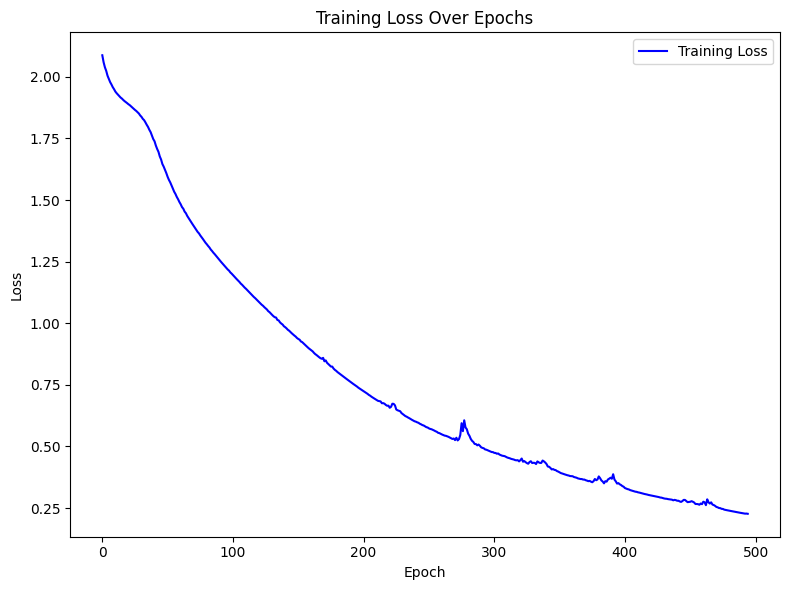

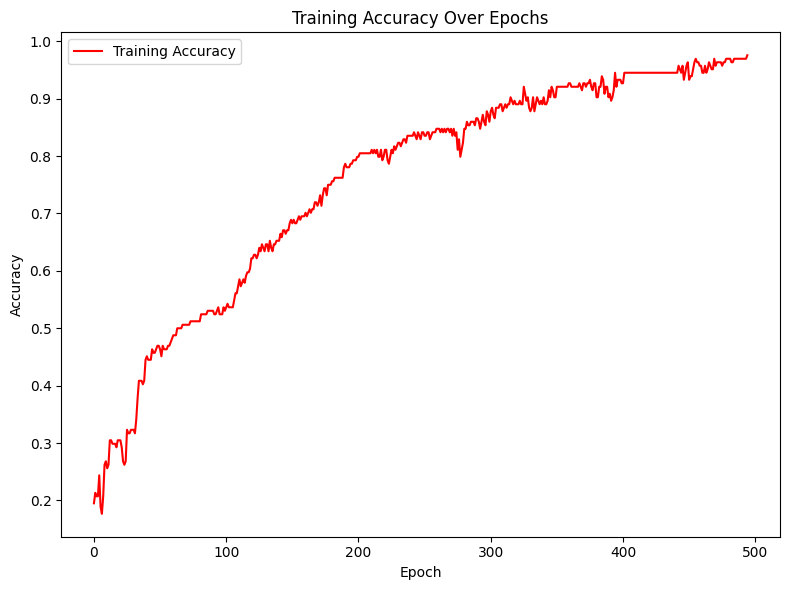

In [48]:
# Plot for Loss
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(L, label='Training Loss', color='blue')  # Plot loss with a label
plt.title('Training Loss Over Epochs')  # Title of the plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.grid(False)  # Add grid lines for better readability
plt.legend()  # Show legend to identify the line plot
plt.tight_layout()  # Adjust the layout to make room for the elements
plt.show()  # Display the plot

# Plot for Accuracy
plt.figure(figsize=(8, 6))  # Set figure size for the accuracy plot
plt.plot(A, label='Training Accuracy', color='red')  # Plot accuracy with a label
plt.title('Training Accuracy Over Epochs')  # Title of the plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.grid(False)  # Add grid lines for better readability
plt.legend()  # Show legend
plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plot

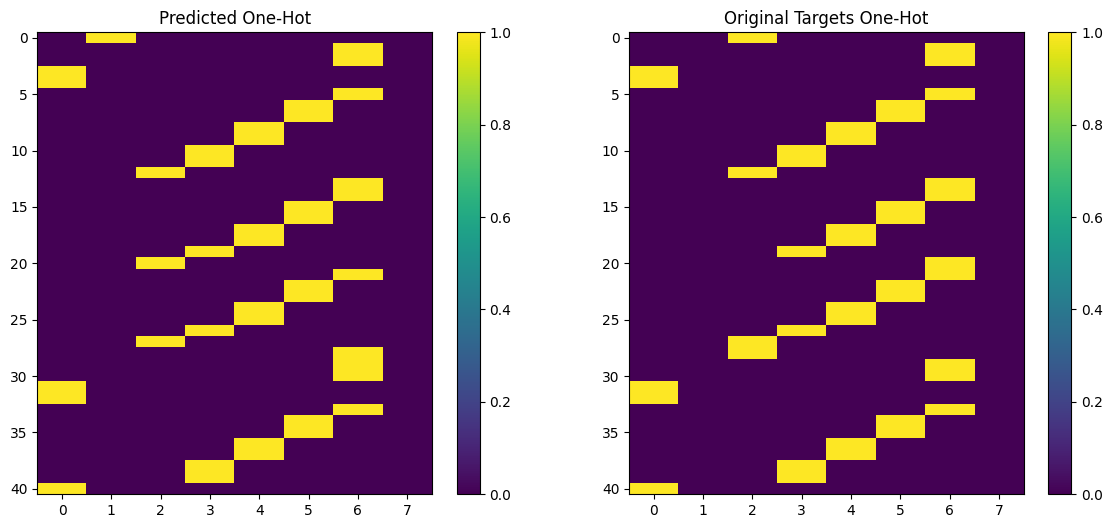

In [49]:
I, O, raw  = generateIOData(0) 

inputs = torch.Tensor(I).unsqueeze(0)  
outputs = model(inputs)

_, predicted_indices = torch.max(outputs, 2)

num_classes = 8 

predicted_one_hot = F.one_hot(predicted_indices.squeeze(), num_classes=num_classes).numpy()


O_tensor = torch.tensor(O, dtype=torch.long)
original_one_hot = F.one_hot(O_tensor, num_classes=num_classes).numpy()


plt.figure(figsize=(14, 6))

# Plotting one-hot encoded predicted indices
plt.subplot(1, 2, 1)
plt.imshow(predicted_one_hot, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Predicted One-Hot')

# Plotting one-hot encoded original targets
plt.subplot(1, 2, 2)
plt.imshow(original_one_hot, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Original Targets One-Hot')

plt.show()

In [3]:
class RNN(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x,verbose= False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        self.store = copy.deepcopy(self.h0.detach().numpy())
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## Attention layer

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

## RNNA

In [5]:
class RNNA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(RNNA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp)  

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        
        attn_out = self.attention(x)
        
        expanded_attn_out = self.expand_layer(attn_out)
        
        expanded_attn_out = torch.relu(expanded_attn_out)

        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        
        rnn_out, self.hidden = self.rnnLayer(expanded_attn_out, h0)
        self.store = self.hidden.detach().numpy().copy()
        out = self.outputLayer(rnn_out)

        return out
    
    

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


## LSTM

In [6]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        self.outputLayer = nn.Linear(int(self.hidden_dim/2), self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)), torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        out, self.h0 = self.lstmLayer(x, self.h0)

        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)
        self.store = hh
        out = self.outputLayer(out)
        return out

        
    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    


## LSTMA

In [7]:
class LSTMA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(LSTMA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp)  

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        self.outputLayer = nn.Linear(int(self.hidden_dim/2), self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        
        attn_out = self.attention(x)

        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.relu(expanded_attn_out)

        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        out, self.h0 = self.lstmLayer(expanded_attn_out, self.h0)
        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)
        self.store = hh
        out = self.outputLayer(out)  # Corrected line

        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    


## GRU

In [8]:
class GRU(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.GRULayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.GRULayer(x, self.h0)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        self.store = self.h0.detach().numpy().copy()
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.GRULayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## GRUA

In [9]:
class GRUA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(GRUA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp) 
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        attn_out = self.attention(x)

        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.relu(expanded_attn_out)

        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
    
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        self.store = self.h0.detach().numpy().copy()
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

    
                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)



In [10]:
def train_model(model, num_epochs, songStrings, number_of_Songs = 4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    songs = list(range(number_of_Songs))
    L = []
    A = []
    for epoch in range(num_epochs):
        np.random.shuffle(songs)
        lo=numpy.zeros((number_of_Songs))
        acc=numpy.zeros((number_of_Songs))
        total_loss = 0
        total_accuracy = 0
        for song in songs:
            I, O, raw = generateIOData(song)
            inputs = torch.tensor(I, dtype=torch.float).unsqueeze(0)  # Add batch dimension
            targets = torch.tensor(O, dtype=torch.long)  # Targets are now indices

            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 8), targets)  # Reshape for CrossEntropyLoss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            _, predicted_indices = torch.max(outputs, 2)
            accuracy = (predicted_indices.squeeze() == targets).float().mean().item()
            acc[song] = accuracy
            total_accuracy += accuracy
            lo[song]=loss.item()
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {total_loss / number_of_Songs}, Accuracy: {total_accuracy / number_of_Songs}')
            print(f'Epoch {epoch+1}, Loss: {mean(lo)}, Losses: {numpy.round(lo,2)}')
            print(f'Epoch {epoch+1}, Accuracy: {mean(acc)}, Accuracies: {numpy.round(acc,2)}')
            
        L.append(total_loss / number_of_Songs)
        
        A.append(total_accuracy / number_of_Songs)
        
        if len(A)>= 5000 or total_accuracy / number_of_Songs >0.97:
            print("Early stopping criteria met")
            break
        
    return L, A

## Train each song without combinations 

In [36]:
models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "LSTM": LSTM(),
    "LSTMA": LSTMA(),  
    "GRU": GRU(),
    "GRUA": GRUA() 
    
}
num_epochs = 5000
number_of_Songs = 4
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    L, A = train_model(model, num_epochs, songStrings, number_of_Songs)
    results[model_name] = {"Accuracy": A, "Loss": L}
    #torch.save(model, f'model_{model_name}_songs.model')

Training RNN...
Epoch 1, Loss: 2.0854634642601013, Accuracy: 0.17073170095682144
Epoch 1, Loss: 2.0854634642601013, Losses: [2.09 2.08 2.08 2.08]
Epoch 1, Accuracy: 0.17073170095682144, Accuracies: [0.1 0.2 0.2 0.2]
Epoch 11, Loss: 1.9767688810825348, Accuracy: 0.17073170468211174
Epoch 11, Loss: 1.9767688810825348, Losses: [2.03 1.95 1.95 1.98]
Epoch 11, Accuracy: 0.17073170468211174, Accuracies: [0.2  0.17 0.15 0.17]
Epoch 21, Loss: 1.8982400596141815, Accuracy: 0.27439023926854134
Epoch 21, Loss: 1.8982400596141815, Losses: [2.   1.83 1.85 1.91]
Epoch 21, Accuracy: 0.27439023926854134, Accuracies: [0.29 0.34 0.29 0.17]
Epoch 31, Loss: 1.8097889721393585, Accuracy: 0.29878049343824387
Epoch 31, Loss: 1.8097889721393585, Losses: [1.93 1.66 1.79 1.86]
Epoch 31, Accuracy: 0.29878049343824387, Accuracies: [0.37 0.2  0.37 0.27]
Epoch 41, Loss: 1.6763909459114075, Accuracy: 0.3780487850308418
Epoch 41, Loss: 1.6763909459114075, Losses: [1.77 1.38 1.73 1.83]
Epoch 41, Accuracy: 0.3780487850

In [35]:
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Final Accuracy: {metrics['Accuracy'][-1]:.4f}")
    print(f"Final Loss: {metrics['Loss'][-1]:.4f}")



Model: RNN
Final Accuracy: 0.2011
Final Loss: 0.9756

Model: RNNA
Final Accuracy: 0.1380
Final Loss: 0.9695

Model: LSTM
Final Accuracy: 0.2157
Final Loss: 0.9756

Model: LSTMA
Final Accuracy: 0.5989
Final Loss: 0.8049

Model: GRU
Final Accuracy: 0.2443
Final Loss: 0.9756

Model: GRUA
Final Accuracy: 0.8190
Final Loss: 0.7378


## Old shrinkingDecompositionInformation

In [254]:
def symbolEntropy(D, base=2):
    value, counts = numpy.unique(D, return_counts=True)  # Find unique values and their frequency in D
    return entropy(counts, base=base)  # Calculate and return the Shannon entropy

# This function seems to compute a complex metric, possibly related to information theory, involving inputs I, hidden states H, and outputs O.
def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    # Create various combinations of Inputs (I), Hidden states (H), and Outputs (O) for analysis
    # B, IB, AB, BO, IAB, IBO, ABO, IABO are different combinations of I, H, and O
    # Calculate entropy for each combination using symbolEntropy
    # Return a specific information metric combining these entropies


    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

# This function seems to analyze how information is processed or transmitted through a network, focusing on individual components (nodes) of the hidden states H.
def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes = list(range(width))  # Initialize a list of node indices
    cols = []  # To store subsets of nodes
    colh = []  # To store corresponding information values
    # Iteratively remove a node, compute information value, and record subsets and values
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh


# This function processes the output of a model given a dataset. It appears to involve some form of clustering (using KMeans) and then re-encoding the hidden states H.
def getOutTaH(model,dataSet):
    O, H = model.step(torch.Tensor(dataSet))  # Get output and hidden states from the model
    # Transform H using clustering and re-encoding

    #print(H.shape,H.min(),H.max())
    #figure()
    #hist(H.flatten())

    H = H.transpose()  # Transpose H for processing
    O = O.transpose()  # Transpose O for processing
    B = numpy.zeros(H.shape)  # Initialize a matrix to store cluster labels for each hidden state
    # Apply KMeans clustering to each hidden state
    # Recompute H as a combination of cluster labels (B)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        x =len(numpy.unique(a))
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

# This function seems to integrate the previous functions to analyze how information flows through the network for different input-output pairs in a dataset.
def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5,dsLength=8):
    output, H = getOutTaH(model, dataSet)  # Get transformed outputs and hidden states from the model
    # Slice output and H to process only specific timesteps
    output=output.transpose()[whichTS::dsLength].transpose()

    #print("target.shape",target.shape,"output.shape",output.shape,"H.shape",H.shape,"dataset.shape",dataSet.shape)
    H=H.transpose()[whichTS::dsLength].transpose()
    #target=target.transpose()[whichTS::dsLength].transpose()
    #print(H.shape,target.shape,numpy.array(range(512))[whichTS::dsLength])

    collectorSet = dict()  # To store information about subsets of nodes (S)
    collectorH = dict()    # To store information values (H)
    # Compute shrinking decomposition information for selected inputs/outputs
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        #print(number,"I.shape",I.shape,"O.shape",O.shape,"H.shape",H.shape)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH


# These functions convert the results of the shrinking decomposition into vector and matrix forms, which are likely used for further analysis or visualization.
def removalIntoVec(res,width,H):
    # Convert the shrinking decomposition results into a vector form

    V = numpy.zeros(width)  # Initialize a vector
    # Calculate values for V based on the difference in information values (H) as nodes are removed
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)

    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]

    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    # Convert the shrinking decomposition results into a matrix form

    M=[]
    # Convert the shrinking decomposition results (S and H) into a matrix form
    # This matrix can be used for visualization or further analysis
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

## generateIOData on each song with its combinations

Input shape: (42, 41, 8), Output (One-Hot) shape: (42, 41, 8), Output (Indices) shape: 42, Each output indices array length: 41


Text(0.5, 1.0, 'Output (One-Hot Encoded)')

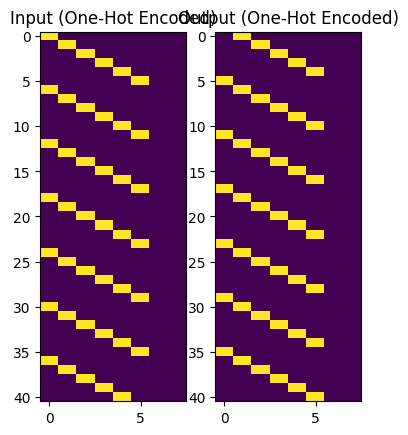

In [25]:
import numpy as np
import matplotlib.pyplot as plt

songStrings = numpy.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])


def generateIOData(songNr, songStrings):
    notes = list("ABCDEFGH")
    source = []
    target_one_hot = []
    target_indices = []
    
    songString = songStrings[songNr]
    
    # Ensure the loop considers the possibility of wrapping around the song's end for a continuous cycle
    for i in range(len(songString)):  # Allow wrapping to get a continuous sequence
        input_one_hot = np.zeros((41, 8))
        output_one_hot = np.zeros((41, 8))
        current_target_indices = []
        
        for j in range(41):  # Build each input window
            input_index = notes.index(songString[(i + j) % len(songString)])
            input_one_hot[j][input_index] = 1.0
            
            if (i + j + 1) < len(songString) + i:  # Wrap around to start for output
                next_char_index = notes.index(songString[(i + j + 1) % len(songString)])
                output_one_hot[j][next_char_index] = 1.0
                current_target_indices.append(next_char_index)
            else:
                current_target_indices.append(0)  # Append a placeholder if beyond song length

        source.append(input_one_hot)
        target_one_hot.append(output_one_hot)
        target_indices.append(current_target_indices)
        
    return np.array(source), np.array(target_one_hot), np.array(target_indices)

# Test the function with a specific song
songNr = 1  # Choose the second song for example
I, O_hot, O_indices = generateIOData(songNr, songStrings)

print(f"Input shape: {I.shape}, Output (One-Hot) shape: {O_hot.shape}, Output (Indices) shape: {len(O_indices)}, Each output indices array length: {len(O_indices[0])}")

# Display the first input and a portion of the output indices for visualization
plt.subplot(1, 3, 1)
plt.imshow(I[0], aspect='auto')
plt.title("Input (One-Hot Encoded)")

plt.subplot(1, 3, 2)
plt.imshow(O_hot[0], aspect='auto')
plt.title("Output (One-Hot Encoded)")




In [273]:
O_indices.shape

(42, 41)

## Train RNNs on each song with its combinations

In [34]:
def train_model(model, num_epochs, songStrings, number_of_Songs = 4):
    L = []
    A = []
    songs = list(range(number_of_Songs))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 1e-3)
    for epoch in range(num_epochs):
        np.random.shuffle(songs)
        total_loss = 0
        total_accuracy = 0
        lo = np.zeros((number_of_Songs))
        acc = np.zeros((number_of_Songs))
        for songNr, song in enumerate(songs):
            I, O_hot, O_indices = generateIOData(songNr, songStrings)
            
            # Prepare for shuffling
            combined = list(zip(I, O_indices))
            np.random.shuffle(combined)
            I_shuffled, O_indices_shuffled = zip(*combined)
            
            # Convert back to numpy arrays if necessary and then to tensors
            I_shuffled = np.array(I_shuffled)
            O_indices_shuffled = np.array(O_indices_shuffled)
            
            inputs = torch.tensor(I_shuffled, dtype=torch.float)  # Inputs are already in the correct shape
            targets = torch.tensor(O_indices_shuffled, dtype=torch.long)  # Use indices for CrossEntropyLoss
            

            # Assuming the model's output shape matches the targets shape
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 8), targets.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            _, predicted_indices = torch.max(outputs, -1)
            correct_predictions = predicted_indices == targets
            accuracy = correct_predictions.float().mean().item()
            acc[songNr] = accuracy
            total_accuracy += accuracy
            lo[songNr] = loss.item()
        avg_loss = total_loss / number_of_Songs
        avg_accuracy = total_accuracy / number_of_Songs

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')
            print(f'Epoch {epoch+1}, Loss: {np.mean(lo)}, Losses: {np.round(lo,2)}')
            print(f'Epoch {epoch+1}, Accuracy: {np.mean(acc)}, Accuracies: {np.round(acc,2)}')
        L.append(avg_loss)
        A.append(avg_accuracy)

        # Early stopping criteria (optional)
        if len(A) > 5000 or avg_accuracy > 0.95:
            print("Early stopping criteria met")
            break

    return L, A

In [13]:
model = RNNA()


num_epochs = 3000
number_of_Songs = 4
L , A = train_model(model, num_epochs, songStrings= songStrings, number_of_Songs = 4)

Epoch 1, Loss: 2.1219, Accuracy: 0.1237
Epoch 1, Loss: 2.121948719024658, Losses: [2.14 2.11 2.18 2.05]
Epoch 1, Accuracy: 0.12369337899144739, Accuracies: [0.01 0.16 0.12 0.21]
Epoch 101, Loss: 1.8018, Accuracy: 0.1969
Epoch 101, Loss: 1.8018265962600708, Losses: [1.82 1.79 1.78 1.82]
Epoch 101, Accuracy: 0.19686411321163177, Accuracies: [0.23 0.17 0.3  0.08]
Epoch 201, Loss: 1.5265, Accuracy: 0.4085
Epoch 201, Loss: 1.5265251994132996, Losses: [1.62 1.07 1.57 1.84]
Epoch 201, Accuracy: 0.4085365757346153, Accuracies: [0.35 0.65 0.33 0.3 ]
Epoch 301, Loss: 1.1375, Accuracy: 0.5983
Epoch 301, Loss: 1.1375225335359573, Losses: [1.08 0.47 1.37 1.63]
Epoch 301, Accuracy: 0.5982868894934654, Accuracies: [0.6  0.97 0.45 0.37]
Epoch 401, Loss: 0.9189, Accuracy: 0.7022
Epoch 401, Loss: 0.9188747927546501, Losses: [0.76 0.31 1.17 1.44]
Epoch 401, Accuracy: 0.702235758304596, Accuracies: [0.7  0.97 0.63 0.51]
Epoch 501, Loss: 0.7527, Accuracy: 0.7625
Epoch 501, Loss: 0.7526635937392712, Losses:

In [35]:
models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "LSTM": LSTM(),
    "LSTMA": LSTMA(),  
    "GRU": GRU(),
    "GRUA": GRUA() 
    
}
num_epochs = 10000
number_of_Songs = 4
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    L, A = train_model(model, num_epochs, songStrings, number_of_Songs)
    results[model_name] = {"Accuracy": A, "Loss": L}
    #torch.save(model, f'model_{model_name}_songs.model')

Training RNN...
Epoch 1, Loss: 2.1057, Accuracy: 0.1439
Epoch 1, Loss: 2.1057199835777283, Losses: [2.1  2.11 2.08 2.13]
Epoch 1, Accuracy: 0.14387340657413006, Accuracies: [0.05 0.17 0.29 0.07]


Epoch 101, Loss: 1.2441, Accuracy: 0.6032
Epoch 101, Loss: 1.2440728545188904, Losses: [1.16 0.51 1.51 1.79]
Epoch 101, Accuracy: 0.6032229959964752, Accuracies: [0.71 0.99 0.42 0.3 ]
Epoch 201, Loss: 0.8126, Accuracy: 0.7487
Epoch 201, Loss: 0.8125804215669632, Losses: [0.71 0.2  1.03 1.3 ]
Epoch 201, Accuracy: 0.7486933916807175, Accuracies: [0.79 0.99 0.69 0.52]
Epoch 301, Loss: 0.5657, Accuracy: 0.8300
Epoch 301, Loss: 0.5656647384166718, Losses: [0.51 0.13 0.72 0.9 ]
Epoch 301, Accuracy: 0.8299941867589951, Accuracies: [0.84 0.99 0.79 0.69]
Epoch 401, Loss: 0.4199, Accuracy: 0.9056
Epoch 401, Loss: 0.4198894537985325, Losses: [0.39 0.1  0.54 0.65]
Epoch 401, Accuracy: 0.9056329876184464, Accuracies: [0.91 0.99 0.86 0.87]
Epoch 501, Loss: 0.3261, Accuracy: 0.9303
Epoch 501, Loss: 0.326123371720314, Losses: [0.31 0.08 0.41 0.5 ]
Epoch 501, Accuracy: 0.9303135871887207, Accuracies: [0.92 0.99 0.9  0.91]
Epoch 601, Loss: 0.2620, Accuracy: 0.9435
Epoch 601, Loss: 0.2620092127472162, Lo

In [36]:
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Final Accuracy: {metrics['Accuracy'][-1]:.4f}")
    print(f"Final Loss: {metrics['Loss'][-1]:.4f}")
    print(f"Number of Epoch: {len(metrics['Accuracy'])}")



Model: RNN
Final Accuracy: 0.9501
Final Loss: 0.1971
Number of Epoch: 798

Model: RNNA
Final Accuracy: 0.9502
Final Loss: 0.1929
Number of Epoch: 1322

Model: LSTM
Final Accuracy: 0.9501
Final Loss: 0.2515
Number of Epoch: 1366

Model: LSTMA
Final Accuracy: 0.9501
Final Loss: 0.2019
Number of Epoch: 3705

Model: GRU
Final Accuracy: 0.9502
Final Loss: 0.2856
Number of Epoch: 452

Model: GRUA
Final Accuracy: 0.9503
Final Loss: 0.1900
Number of Epoch: 1133


In [290]:
 models["RNN"]

RNN(
  (expand_layer): Linear(in_features=8, out_features=20, bias=True)
  (rnnLayer): RNN(20, 20, batch_first=True)
  (outputLayer): Linear(in_features=20, out_features=8, bias=True)
)

(8, 20)

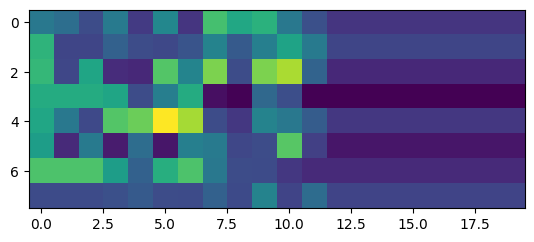

In [236]:
I, O_hot, O_indices = generateIOData(0, songStrings)

S,H=shrinkingDecompositionInformation(model,20,I,O_indices.transpose(),numbers=[0,1,2,3,4,5,6,7],whichTS=40,dsLength=41)
M=removalIntoMatrix(S,20,H)
imshow(M)
M.shape

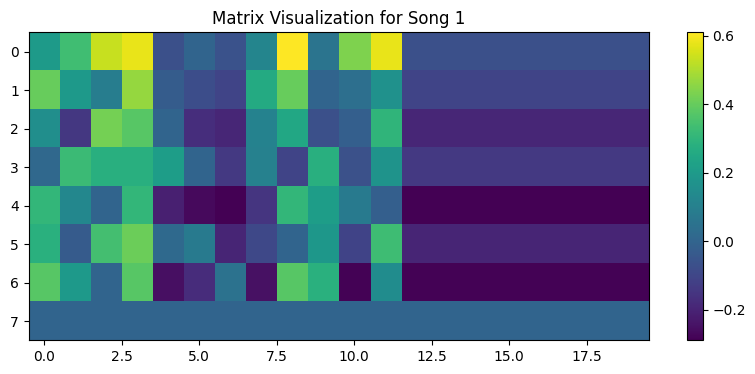

Shape of M for song 1: (8, 20)


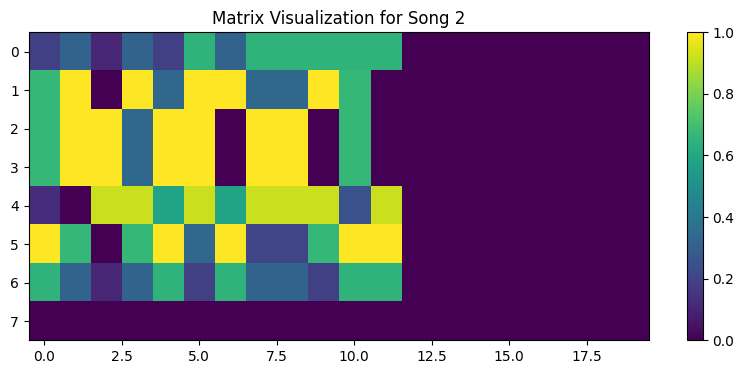

Shape of M for song 2: (8, 20)


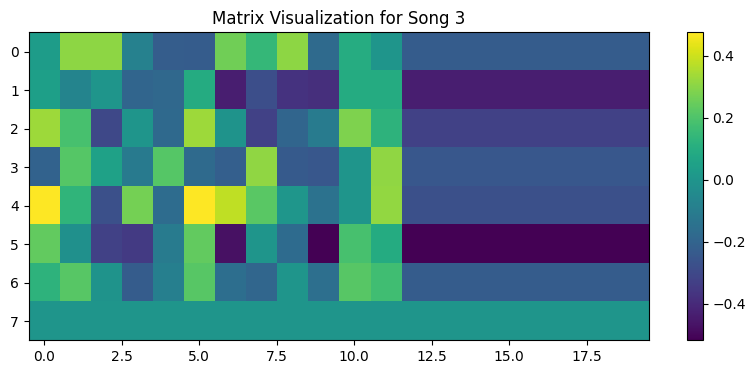

Shape of M for song 3: (8, 20)


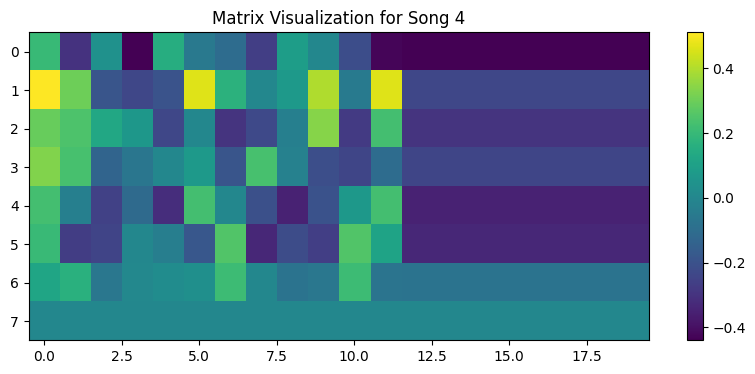

Shape of M for song 4: (8, 20)


In [ ]:
import matplotlib.pyplot as plt

# Assuming the existence of generateIOData, shrinkingDecompositionInformation, and removalIntoMatrix functions.
for i in range(4):
    
    I, O_hot, O_indices = generateIOData(i, songStrings)
    
    # Assuming these functions return the necessary components for plotting
    S, H = shrinkingDecompositionInformation(model, 20, I, O_indices.transpose(), numbers=[0,1,2,3,4,5,6,7], whichTS=40, dsLength=41)
    M = removalIntoMatrix(S, 20, H)
    
    plt.figure(figsize=(10, 4))  # Adjust the figure size as necessary
    plt.imshow(M, aspect='auto')  # 'auto' can adjust the aspect ratio based on array dimensions
    plt.colorbar()  # Show color scale
    plt.title(f'Matrix Visualization for Song {i+1}')
    plt.show()

    print(f"Shape of M for song {i+1}: {M.shape}")

tensor([5, 4, 2, 4, 1, 5, 2, 1, 1, 6, 1, 1, 4, 1, 4, 6, 4, 4, 4, 1, 2, 6, 1, 4,
        1, 4, 1, 1, 2, 1, 4, 1, 2, 4, 1, 5, 5, 1, 1, 5, 6])
tensor([4, 2, 4, 1, 5, 2, 1, 1, 6, 1, 1, 4, 1, 4, 6, 4, 4, 4, 1, 2, 6, 1, 4, 1,
        4, 1, 1, 2, 1, 4, 1, 2, 4, 1, 5, 5, 1, 1, 5, 6, 4])
tensor([2, 4, 1, 5, 2, 1, 1, 6, 1, 1, 4, 1, 4, 6, 4, 4, 4, 1, 2, 6, 1, 4, 1, 4,
        1, 1, 2, 1, 4, 1, 2, 4, 1, 5, 5, 1, 1, 5, 6, 4, 5])
tensor([4, 1, 5, 2, 1, 1, 6, 1, 1, 4, 1, 4, 6, 4, 4, 4, 1, 2, 6, 1, 4, 1, 4, 1,
        1, 2, 1, 4, 1, 2, 4, 1, 5, 5, 1, 1, 5, 6, 4, 5, 4])
(820, 4)


(820, 4)


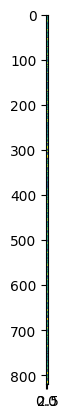

In [20]:
I, O_hot, O_indices = generateIOData(4, songStrings)
songs =np.array([0,1,2,3])
s,h=shrinkingDecompositionInformation(model,I,O_indices,songs,numbers=list(range(4)),width=20)

0.5 0.0


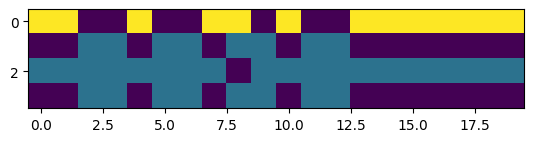

In [21]:
M=removalIntoMatrix(s,20,h)
imshow(M)
print(M.max(),M.min())

## generateIOData on all songs at once with its corresponding combinations

Input shape: (168, 41, 8), Output (One-Hot) shape: (168, 41, 8), Output (Indices) shape: (168, 41)


Text(0.5, 1.0, 'Output (One-Hot Encoded)')

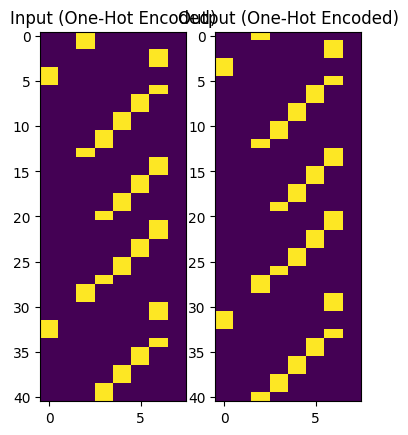

In [90]:
songStrings = numpy.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

def generateIOData(nrOfSongs,songStrings):
    notes = list("ABCDEFGH")
    source = []
    target_one_hot = []
    target_indices = []
    raw_target = []

    for s in range(nrOfSongs):
        for i in range(42):  # Adjust for loop to cover up to the second last character
            input_one_hot = np.zeros((41, 8))
            current_target_one_hot = np.zeros((41, 8))
            current_target_indices = np.zeros(41, dtype=int)
            for j in range(41):
                if (i + j) < len(songStrings[s]):  # Ensure we don't exceed the song's length
                    input_index = notes.index(songStrings[s][(i+j) % len(songStrings[s])])
                    input_one_hot[j][input_index] = 1.0
                    if (i + j + 1) < len(songStrings[s]):
                        target_index = notes.index(songStrings[s][(i+j+1) % len(songStrings[s])])
                        current_target_one_hot[j][target_index] = 1.0
                        current_target_indices[j] = target_index
            source.append(input_one_hot)
            target_one_hot.append(current_target_one_hot)
            target_indices.append(current_target_indices)  # Append the array of indices for this input window
            raw_target.append(target_index)  # Keep track of the target indices
    return np.array(source), np.array(target_one_hot), np.array(target_indices) , np.array(raw_target)

I, O_hot, O_indices, songs = generateIOData(4,songStrings)
print(f"Input shape: {I.shape}, Output (One-Hot) shape: {O_hot.shape}, Output (Indices) shape: {O_indices.shape}")

# Display the first input and raw output for visualization
plt.subplot(1, 3, 1)
plt.imshow(I[0], aspect='auto')
plt.title("Input (One-Hot Encoded)")
plt.subplot(1, 3, 2)
plt.imshow(O_hot[0], aspect='auto')
plt.title("Output (One-Hot Encoded)")


In [91]:
songs

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [130]:
def test(model, source, target):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        
        # The output is [sequence_length, batch_size, ntokens]. Get the most likely token predictions
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability
        #print(predictions)
        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions
        
    accuracy = correct / total  # Calculate the accuracy
    return accuracy

 ## Train Rnns on all songs at once with its corresponding combinations

In [58]:
def train_model(model, num_epochs, songStrings, number_of_Songs):
    L = []  # Losses
    A = []  # Accuracies
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 1e-3)
    
    # Assuming generateIOData has been adjusted to take only songStrings
    I, _, O_indices, songs = generateIOData(number_of_Songs,songStrings)  # Use the full dataset
    #print(f"Input shape: {I.shape}, Output (Indices) shape: {O_indices.shape}")
    # Convert the dataset to tensors
    inputs = torch.tensor(I, dtype=torch.float)
    targets = torch.tensor(O_indices, dtype=torch.long)

    for epoch in range(num_epochs):
        optimizer.zero_grad()  # Zero the gradients at the start of each epoch
        
        # Shuffle dataset
        indices = torch.randperm(inputs.size(0))
        inputs_shuffled = inputs[indices]
        targets_shuffled = targets[indices]
        
        # Assuming the model expects inputs of shape [seq_len, batch, feature]
        src = inputs_shuffled
        tgt = targets_shuffled
        #print(f"src shape: {src.shape}, tgt shape: {tgt.shape}")
        # Forward pass
        outputs = model(src)
        output_flat = outputs.view(-1, outputs.shape[-1])  # Flatten output for CrossEntropyLoss
        loss = criterion(output_flat, tgt.view(-1))
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_loss = loss.item()

        # Calculate accuracy
        _, predicted_indices = torch.max(output_flat, 1)
        print(f'predicted { predicted_indices}')
        print(f'target {tgt.view(-1)}')
        correct_predictions = (predicted_indices == tgt.view(-1)).sum().item()
        total_accuracy = correct_predictions / tgt.numel()
        
        # Log the loss and accuracy
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {total_accuracy:.4f}')
        
        L.append(total_loss)
        A.append(total_accuracy)

        # Early stopping criteria (optional)
        if total_accuracy >= 0.97:
            print("Early stopping criteria met")
            break

    return L, A

In [61]:
model = RNN()
num_epochs = 7000
number_of_Songs = 4
L, A  = train_model(model, num_epochs, songStrings= songStrings, number_of_Songs = 4)

predicted tensor([3, 2, 0,  ..., 2, 2, 2])
target tensor([2, 3, 4,  ..., 0, 0, 0])
Epoch 1, Loss: 2.0266, Accuracy: 0.0495
predicted tensor([3, 2, 0,  ..., 2, 2, 2])
target tensor([2, 0, 2,  ..., 0, 0, 0])
predicted tensor([3, 2, 0,  ..., 2, 2, 2])
target tensor([2, 3, 4,  ..., 0, 0, 0])
predicted tensor([3, 0, 2,  ..., 0, 2, 0])
target tensor([1, 2, 3,  ..., 0, 0, 0])
predicted tensor([2, 0, 0,  ..., 0, 0, 0])
target tensor([2, 1, 0,  ..., 0, 0, 0])
predicted tensor([3, 0, 0,  ..., 0, 0, 0])
target tensor([4, 4, 3,  ..., 0, 0, 0])
predicted tensor([3, 0, 2,  ..., 0, 0, 0])
target tensor([1, 2, 3,  ..., 0, 0, 0])
predicted tensor([3, 0, 0,  ..., 0, 0, 0])
target tensor([6, 5, 5,  ..., 0, 0, 0])
predicted tensor([2, 0, 0,  ..., 0, 0, 0])
target tensor([2, 6, 6,  ..., 0, 0, 0])
predicted tensor([3, 0, 0,  ..., 0, 0, 0])
target tensor([1, 2, 0,  ..., 0, 0, 0])
predicted tensor([3, 0, 0,  ..., 0, 0, 0])
target tensor([0, 6, 5,  ..., 0, 0, 0])
predicted tensor([0, 0, 0,  ..., 0, 0, 0])
targ

In [27]:
models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "LSTM": LSTM(),
    "LSTMA": LSTMA(),  
    "GRU": GRU(),
    "GRUA": GRUA() 
    
}
number_of_Songs = 4
num_epochs = 7000
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    L , A = train_model(model, num_epochs, songStrings, number_of_Songs)
    results[model_name] = {"Accuracy": A, "Loss": L}
    #torch.save(model, f'model_{model_name}_songs.model')

Training RNN...
Epoch 1, Loss: 2.2120, Accuracy: 0.1161
Epoch 101, Loss: 1.3491, Accuracy: 0.5719
Epoch 201, Loss: 0.9376, Accuracy: 0.6549
Epoch 301, Loss: 0.7356, Accuracy: 0.7699
Epoch 401, Loss: 0.6032, Accuracy: 0.8063
Epoch 501, Loss: 0.5142, Accuracy: 0.8328
Epoch 601, Loss: 0.4390, Accuracy: 0.8650
Epoch 701, Loss: 0.3735, Accuracy: 0.8991
Epoch 801, Loss: 0.3155, Accuracy: 0.9210
Epoch 901, Loss: 0.2669, Accuracy: 0.9357
Epoch 1001, Loss: 0.2323, Accuracy: 0.9441
Epoch 1101, Loss: 0.2076, Accuracy: 0.9499
Epoch 1201, Loss: 0.1887, Accuracy: 0.9519
Epoch 1301, Loss: 0.1741, Accuracy: 0.9551
Epoch 1401, Loss: 0.1623, Accuracy: 0.9567
Epoch 1501, Loss: 0.1525, Accuracy: 0.9576
Epoch 1601, Loss: 0.1443, Accuracy: 0.9599
Epoch 1701, Loss: 0.1373, Accuracy: 0.9617
Epoch 1801, Loss: 0.1313, Accuracy: 0.9627
Epoch 1901, Loss: 0.1261, Accuracy: 0.9636
Epoch 2001, Loss: 0.1215, Accuracy: 0.9639
Epoch 2101, Loss: 0.1173, Accuracy: 0.9649
Epoch 2201, Loss: 0.1135, Accuracy: 0.9657
Epoch 2

In [28]:
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Final Accuracy: {metrics['Accuracy'][-1]:.4f}")
    print(f"Number of Epoch: {len(metrics['Accuracy'])}")
    print(f"Final Loss: {metrics['Loss'][-1]:.4f}")



Model: RNN
Final Accuracy: 0.9702
Number of Epoch: 3026
Final Loss: 0.0926

Model: RNNA
Final Accuracy: 0.9310
Number of Epoch: 7000
Final Loss: 0.2078

Model: LSTM
Final Accuracy: 0.9697
Number of Epoch: 7000
Final Loss: 0.0989

Model: LSTMA
Final Accuracy: 0.9701
Number of Epoch: 5399
Final Loss: 0.1237

Model: GRU
Final Accuracy: 0.9701
Number of Epoch: 2197
Final Loss: 0.0878

Model: GRUA
Final Accuracy: 0.9701
Number of Epoch: 5433
Final Loss: 0.1076


In [88]:
model.store[-1].shape

(168, 20)

In [133]:
I, _, O_indices, songs = generateIOData(number_of_Songs,songStrings)  # Use the full dataset
I.shape

(168, 41, 8)

In [58]:
I, O_hot, O_indices, songs = generateIOData(4, songStrings)
S,H=shrinkingDecompositionInformation(model,20,source,target.transpose(),numbers=[0,1,2,3,4,5,6,7],whichTS=40,dsLength=41)
M=removalIntoMatrix(S,20,H)
imshow(M)
M.shape

NameError: name 'shrinkingDecompositionInformation' is not defined

## predict_next_token

In [15]:
def predict_next_token(model, token_indices,verbose=False):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Convert the list of token indices to a PyTorch tensor and add a batch dimension
    src = torch.tensor(token_indices, dtype=torch.float).unsqueeze(1)  # Shape [sequence_length, 1] to match expected input
    
    with torch.no_grad():
        output = model(src,verbose)  # Get model output for the entire sequence

    # Assuming output is [sequence_length, 1, ntokens] and we're interested in the last token's prediction
    output_flat = output.view(-1, output.shape[-1])  # Flatten output for CrossEntropyLoss

    _, predicted_indices = torch.max(output_flat, 1)
    print(predicted_indices)
    
    last_token_logits = output[-1, 0, :]  # Get logits for the last token
    predicted_token_index = last_token_logits.argmax().item()  # Find the index of the max log-probability
    
    return predicted_token_index

# Example usage:
# Assuming you have a `model` instance and a sentence represented as a list of token indices
# token_indices = [1, 2, 3, 2, 1, 2, 3, ...]
who=40
I[who]
print(source[who].shape)
predicted_token_index = predict_next_token(model, source[who],verbose=True)
print(f'Predicted next token index: {predicted_token_index}')
print(f"original target {target[who][-1]}")

TypeError: 'function' object is not subscriptable

In [43]:
target[who]

array([0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4,
       4, 3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 0, 0, 0])

## New shrinkingDecompositionInformation

In [18]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def getAllIOH(model,source,target,songs,width=20):
    I=[]
    O=[]
    H=[]
    for i in range(len(songs)):
        I.append(songs[i])
        predicted_token_index = predict_next_token(model, source[i])
        if predicted_token_index==target[i][-1]:
            O.append(songs[i])
        else:
            O.append((songs[i]+1)%max(songs))
        H.append(list(model.store[-1].flatten()))
    H=numpy.array(H).transpose()
    print(H.shape)
    imshow(H)
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
    print(B.shape)
    H=numpy.zeros((H.shape[1]))
    for i in range(width):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return numpy.array(I),numpy.array(O),H

def shrinkingDecompositionInformation(model,source,target,songs,numbers=[0,1,2,3],width=20):
    allI,allO,H=getAllIOH(model,source,target,songs,width=width)
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=(1*(songs==number)).astype(int)
        O=(1*(allO==number)).astype(int)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)



In [ ]:
source, O_hot, target, songs = generateIOData(4, songStrings)

s,h=shrinkingDecompositionInformation(model,source,target,songs,numbers=list(range(4)),width=20)

In [102]:
M=removalIntoMatrix(s,20,h)

0.5 0.0


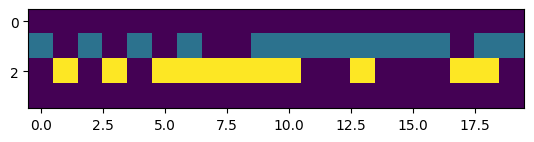

In [105]:
imshow(M)
print(M.max(),M.min())

(820, 168)
(820, 168)
(820, 168)
(820, 168)
(820, 168)
(820, 168)
(820, 168)
(820, 168)
(820, 168)
(820, 168)
(820, 168)
(820, 168)


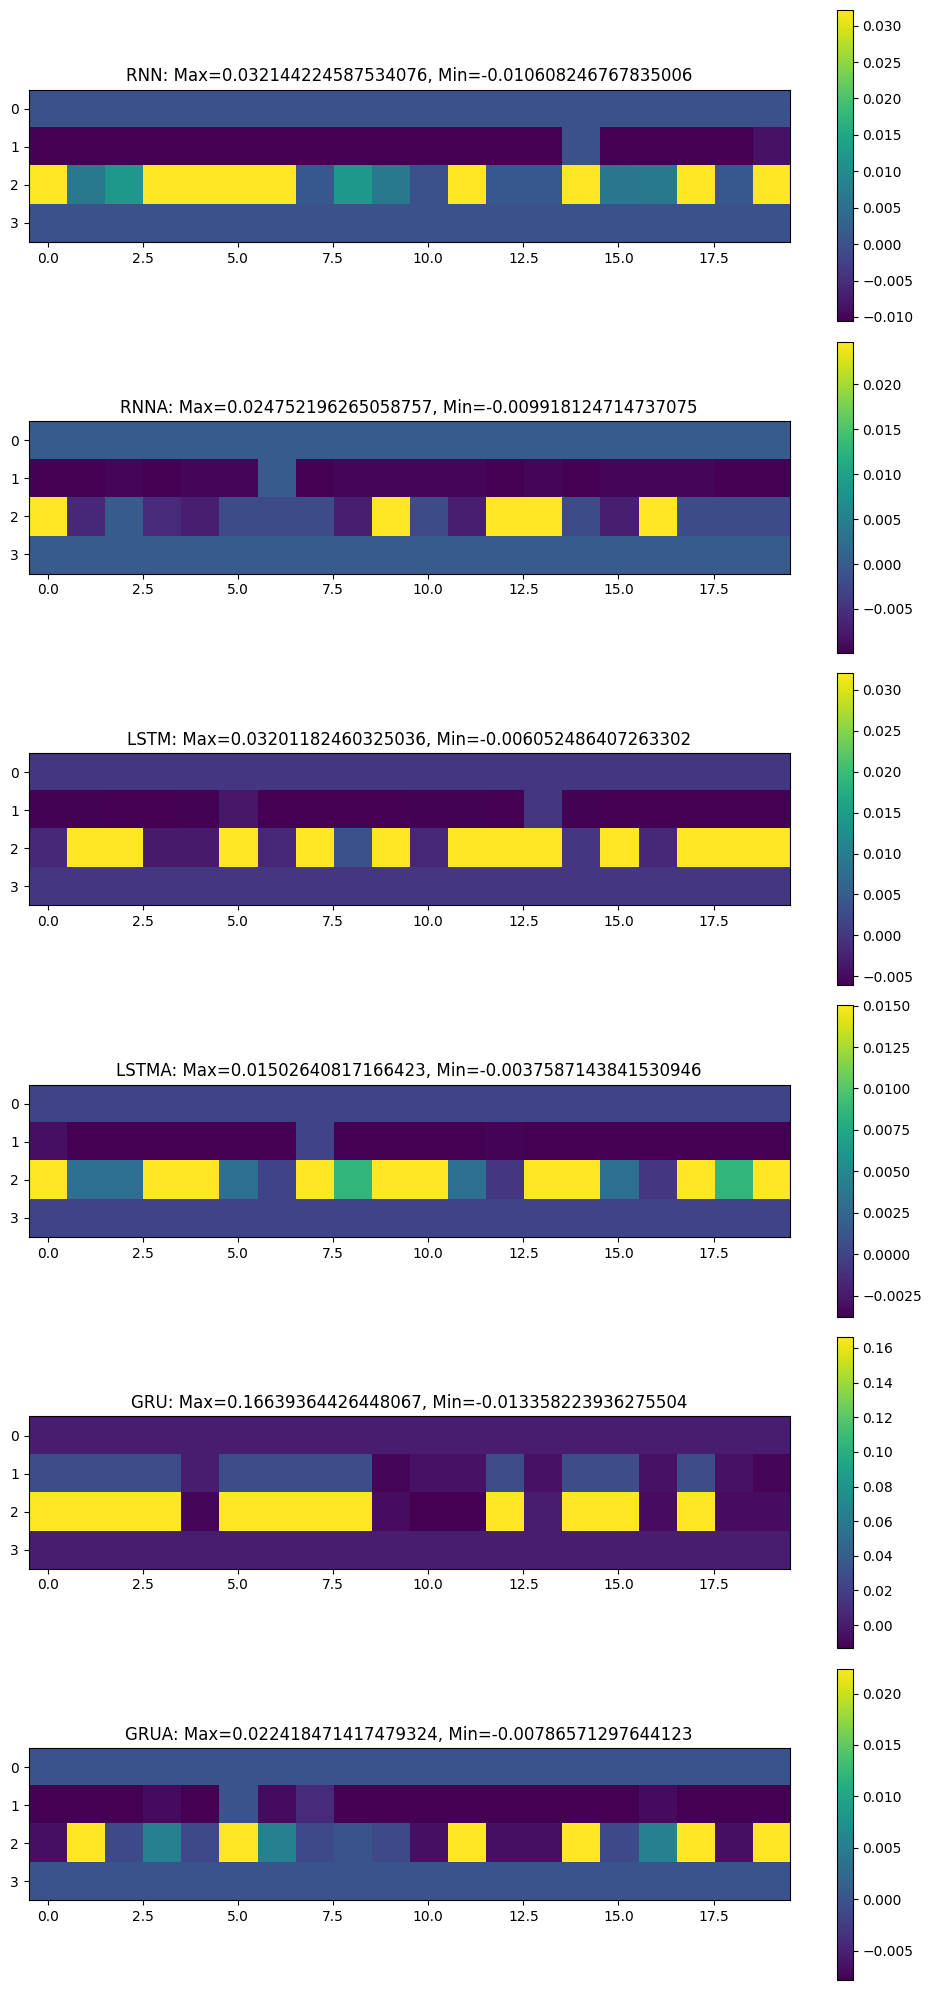

In [33]:
models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "LSTM": LSTM(),
    "LSTMA": LSTMA(),  
    "GRU": GRU(),
    "GRUA": GRUA() 
    
}
source, O_hot, target, songs = generateIOData(4, songStrings)
fig, axs = plt.subplots(len(models), 1, figsize=(10, 20))

# For each model, process the data and plot the resulting matrix
for i, (model_name, model) in enumerate(models.items()):
    s, h = shrinkingDecompositionInformation(model, source, target, songs, numbers=list(range(4)), width=20)
    M = removalIntoMatrix(s, 20, h)
    
    ax = axs[i]
    cax = ax.imshow(M)
    fig.colorbar(cax, ax=ax)
    ax.set_title(f"{model_name}: Max={M.max()}, Min={M.min()}")

plt.tight_layout()
plt.show()


In [271]:
source

array([[[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [269]:
target[0]

array([2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6,
       5, 5, 4, 4, 3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2])

In [270]:
songs

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [119]:
def generateIODataV2(songStrings, num_songs, seq_length=42):
    notes = list("ABCDEFGH")  # List of unique notes
    source = []
    target = []
    raw = []
    for s in range(num_songs):  # Loop through the specified number of songs
        song = songStrings[s]
        for i in range(len(song) - seq_length + 1):
            # Generate input sequence and the corresponding target sequence
            input_seq = [notes.index(note) for note in song[i:i+seq_length]]
            target_seq = [notes.index(note) for note in song[i+1:i+seq_length+1]]
            source.append(input_seq)
            target.append(target_seq)
            raw.append(s)
    # Convert input sequences to one-hot encoding
    source_one_hot = np.zeros((len(source), seq_length, len(notes)), dtype=np.float32)
    for i, seq in enumerate(source):
        for j, note_index in enumerate(seq):
            source_one_hot[i, j, note_index] = 1.0

    target_array = np.array(target)  # Convert target sequences to a NumPy array

    return source_one_hot, target_array

In [91]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, input_dim = 42, hidden_dim =20, output_dim = 41, num_layers=1):
        super(Seq2SeqRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.outputLayer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.outputLayer(out)
        return out

In [92]:
def train_model(model, inputs, targets, num_epochs=1000, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(num_epochs):
        model.zero_grad()
        outputs = model(inputs)
        outputs_reshaped = outputs.reshape(-1, outputs.shape[2])
        targets_reshaped = targets.reshape(-1)
        loss = criterion(outputs_reshaped, targets_reshaped)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')
    
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    return model

In [124]:
inputs, targets = generateIODataV2(songStrings, 4)


In [127]:
inputs.shape

(4, 42, 8)

In [96]:
input_dim = len("ABCDEFGH")  # Number of unique notes
hidden_dim = 64  # Adjust based on performance
output_dim = input_dim  # Same as input because of one-hot encoding
num_layers = 1  # Can be adjusted for model complexity

# Prepare data
inputs, targets = generateIODataV2(songStrings, 4)
inputs_tensor = torch.tensor(inputs, dtype=torch.float)
targets_tensor = torch.tensor(targets, dtype=torch.long)

# Initialize model
model = Seq2SeqRNN(input_dim, hidden_dim, output_dim, num_layers)

# Train model
trained_model = train_model(model, inputs_tensor, targets_tensor, num_epochs=1000, learning_rate=0.001)

Epoch 0/1000, Loss: nan
Epoch 100/1000, Loss: nan
Epoch 200/1000, Loss: nan
Epoch 300/1000, Loss: nan
Epoch 400/1000, Loss: nan


KeyboardInterrupt: 